In [1]:
!pip install -r requirements.txt --user

^C


## Imports


In [1]:
import pandas as pd
from LPA import Corpus, sockpuppet_distance , PCA
import altair as alt
alt.data_transformers.disable_max_rows()
import os
from typing import List
from visualize import plot_pca
import re
from collections import Counter
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import zipfile
from bs4 import BeautifulSoup
import shutil
import html2text
import re
import ast
import scipy.stats as stats
from sklearn.metrics import f1_score, precision_score, recall_score
import random
import datetime


## Functions

In [2]:
def make_dirs_topic(experimentpath , experimentnum):# Set up directories for the experiment
    os.makedirs(experimentpath , exist_ok=True)
    os.makedirs(experimentpath+"/Images-"+experimentnum , exist_ok=True)
    #Signatures Folders
    os.makedirs(experimentpath+"/Signatures" , exist_ok=True)
    #Results Folders
    os.makedirs(experimentpath+"/Results" , exist_ok=True)
#     os.makedirs(experimentpath+"/Results/dvrs" , exist_ok=True)
#     os.makedirs(experimentpath+"/Results/Prompts" , exist_ok=True)
#     os.makedirs(experimentpath+"/Results/Distances" , exist_ok=True)

## Read All csvs From Folder

In [3]:
def wordfreq_random_files(prompt_folder , num_files=2):
    # Get a list of all files in the prompt folder
    all_files = os.listdir(prompt_folder)
    
    # If the sample size is larger than the number of files, set the sample size to the number of files
    sample_size = min(num_files, len(all_files))
    
    # Select num_files random files from the list
    random_files = random.sample(all_files, sample_size)
    dfs = []

    # Loop through each file in the directory
    for file_name in random_files:
        # Check if the file is a CSV file
        if file_name.endswith('.csv'):
            # Read the file into a DataFrame and append it to the list
            file_path = os.path.join(prompt_folder, file_name)
            df = pd.read_csv(file_path)
            dfs.append(df)
    # Concatenate all the DataFrames into a single DataFrame
    df = pd.concat(dfs, ignore_index=True)
    return df

Export Signatures

In [4]:
def export_signatures(dataframes: List[pd.DataFrame] , outputFolder="LPAresults/signitures/" , index=True):
    for df in dataframes:
        filename = df.name + '-Signature.csv'
        df.to_csv(outputFolder+ filename, index=index)

Plots

In [74]:
def plot1_again(df , field = "Distance" , color = "blue" , label = "Fanfiction" , threshold=None
         ,save_format ="jpg" , filename="plot.jpg" , out_path = "/Images" ):
    # Create a figure and axis object
    fig, ax = plt.subplots()

    # Create a histogram of the "distance" column in df_fanfiction, colored blue
    ax.hist(df[field], bins=500, alpha=0.5, color=color, label=label)
        # Set the x and y axis labels
    ax.set_xlabel("Distance")
    ax.set_ylabel("Frequency")

    # Add a legend
    ax.legend()
    if threshold is not None:
        ax.axvline(x=threshold, color='black', linestyle='--')
        ax.text(threshold, ax.get_ylim()[1]*1.05, f'Threshold: {threshold:.2f}', ha='center', va='top', fontsize=12)
    fig.set_facecolor('white')
    fig.savefig(os.path.join(out_path, filename), format=save_format , dpi=300)

In [6]:
def get_current_date():
    """Returns the current date in the format YYYY-MM-DD"""
    current_date = datetime.datetime.now()
    formatted_date = current_date.strftime("%Y-%m-%d")
    return formatted_date


Make 1 big dataframe of all the real stories

In [7]:
def makebigdf(folder_path):
    # List of all CSV files in the folder
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    # Initialize an empty list to store dataframes
    dfs = []

    # Iterate over each CSV file and read it into a dataframe
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        dfs.append(df)

    # Concatenate all dataframes into one big dataframe
    big_df = pd.concat(dfs, ignore_index=True)
    return big_df

Similarity

In [65]:
def rename_matrix(df , starts = 'write me'):
    for col in df.columns:
        if col.lower().startswith(starts.lower()):
            df.rename(columns={col: 'prompt'}, inplace=True)
        else:
            df.rename(columns={col: 'real'}, inplace=True)
    for i, index_name in enumerate(df.index):
        if index_name.lower().startswith(starts.lower()):
            df.rename(index={index_name: 'prompt ' + str(i)}, inplace=True)
        else:
            df.rename(index={index_name: 'real ' + str(i)}, inplace=True)
    return df


Calculate Distances

In [9]:
def calculate_distances(dvr_path, folder, outpath):
    """
    Calculates the Euclidean distances between a reference vector (the global_weight column of df)
    and all other vectors in a folder containing dataframes representing vectors.
    
    Args:
    - df (pd.DataFrame): A pandas DataFrame containing a column named 'global_weight' that will
    be used as the reference vector.
    - folder (str): Path to the folder containing CSV files representing other vectors.
    
    Returns:
    - A pandas DataFrame containing the distances between the reference vector and all other vectors.
    """
    dvr_frame = pd.read_csv(dvr_path, low_memory = False)
    # Create an empty list to hold the distances
    distances = []
    
       # Iterate over all CSV files in the folder
    for file_name in os.listdir(folder):
        # Check if the file is a CSV file
        if file_name.endswith('.csv'):
            # Load the CSV file into a pandas DataFrame
            df = pd.read_csv(os.path.join(folder, file_name))
            # Calculate the Euclidean distance between the reference vector and the current vector
            distance = compute_distance(dvr_frame, df)
            # Add the distance to the list
            distances.append(distance)
            
    distances_df = pd.DataFrame(distances, columns=['Distance'], index=os.listdir(folder))
    
    distances_df.to_csv(outpath,mode='w',header=True, index=True)
    return distances_df


In [10]:
def split_dataframe_by_index(df, index_names=["write me"]):
    """
    Splits a dataframe into two based on the names of the indexes.

    Args:
    df: The dataframe to split.
    index_names: The names of the indexes to include in the first dataframe. Default is ["write me"].

    Returns:
    A tuple of two dataframes. The first dataframe will contain the rows whose indexes start with the names in `index_names`. The second dataframe will contain the rows whose indexes do not start with any of the names in `index_names`.
    """

    # Convert index_names to lowercase for a case-insensitive search.
    index_names_lower = [name.lower() for name in index_names]

    # Get the rows whose indexes start with "write me" (case-insensitive) or any index names in index_names.
    prompts_df = df[df.index.str.lower().str.startswith(tuple(index_names_lower))]

    # Get the rows whose indexes do not start with any of the names in `index_names`.
    non_prompts_df = df[~df.index.str.lower().str.startswith(tuple(index_names_lower))]

    return prompts_df, non_prompts_df

Run Experiment

In [76]:
def run_Experiment(out_path ,  key_word, exp_date, experiment_num = 1 ,to_spd = False , dataset_folder = "Dataset/Data/"):
#     real_freq_path = r"Dataset\Food_Data\Recipes\upto2recipes_undivided\word_freq"
#     prompts_freq_path = r"Dataset\Food_Data\Recipes\prompts\word_freq"
    real_freq_path = r"Dataset\Food_Data\Recipes\undivided_after_cleaning\word_freq"
    prompts_freq_path = r"Dataset\Food_Data\Recipes\prompts_after_cleaning\word_freq"
    #  Make Directories
    out_folder = out_path+"/"+key_word+"/experiment-"+str(experiment_num)
    os.makedirs(out_path+"/"+key_word , exist_ok=True)
    make_dirs_topic(out_folder , exp_date)
    
    # Choose Files For LPA
    real_freq = wordfreq_random_files(real_freq_path , num_files=4500)
    prompt_freq = wordfreq_random_files(prompts_freq_path , num_files=2)
    freq = pd.concat([real_freq , prompt_freq], ignore_index=True)
    freq.rename(columns={'origin_index': 'document', 'word': 'element' , 'frequency': 'frequency_in_document'}, inplace=True)
    
    #Create Corpus
    corpus = Corpus(freq=freq)
    
    #Create DVR
    dvr = corpus.create_dvr()
    dvr_path = out_folder+"/"+key_word+"- exp "+str(experiment_num)+"-dvr.csv"
    dvr.to_csv(dvr_path ,mode='w',header=True, index=False)
    
    #Create Epsilon
    epsilon_frac = 2
    epsilon = 1 / (len(dvr) * epsilon_frac)
    
    #Create Signatures
    signatures = corpus.create_signatures(epsilon=epsilon, sig_length=100, distance="KLDe")
    export_signatures(signatures , outputFolder = out_folder+"/Signatures/")
    
    ## Distances 
    all_distances = calculate_distances(dvr_path , out_folder+"/Signatures/" , out_folder+"/Results/all-distances.csv")
    prompts_dis, non_prompts_dis =split_dataframe_by_index(all_distances , index_names=["Prompt-"])
    non_prompts_dis.to_csv(out_folder+"/Results/non_prompts-distances.csv" ,mode='w',header=True, index=True)
    prompts_dis.to_csv(out_folder+"/Results/prompts-distances.csv" ,mode='w',header=True, index=True)
    
    if to_spd:
        sockpuppet_distance
        spd = sockpuppet_distance(corpus, corpus , res = "matrix")
        spd.to_csv(out_folder+"/Results/SPD_Matrix.csv",mode='w',header=True, index=True)
        spd_heatmap = rename_matrix(spd, starts ="Prompt-")
        fig = plt.figure(figsize=(15, 15))
        heatmap = sns.heatmap(spd_heatmap, cmap='viridis', annot=False ,ax=fig.gca())
        heatmap.figure.savefig(out_folder+"/Images-"+exp_date+"/heatmap.jpg")
    plot1_again(non_prompts_dis , filename=key_word+"-fanfiction_histogram.jpg" , out_path = out_folder+"/Images-"+exp_date)
    plot1_again(prompts_dis , color = "red" , label = "Prompts" , 
                filename=key_word+"-prompts_histogram.jpg" , out_path = out_folder+"/Images-"+exp_date)
    return non_prompts_dis , prompts_dis 

In [77]:
def run_Experiment_rp(out_path ,  key_word, exp_date, experiment_num = 1 ,to_spd = False , dataset_folder = "Dataset/Data/"):
#     real_freq_path = r"Dataset\Food_Data\Recipes\upto2recipes_undivided\word_freq"
#     prompts_freq_path = r"Dataset\Food_Data\Recipes\prompts\word_freq"
    real_freq_path = r"Dataset\Food_Data\Recipes\undivided_after_cleaning\word_freq"
    prompts_freq_path = r"Dataset\Food_Data\Recipes\prompts_after_cleaning\word_freq"
    #  Make Directories
    out_folder = out_path+"/"+key_word+"/experiment-"+str(experiment_num)
    os.makedirs(out_path+"/"+key_word , exist_ok=True)
    make_dirs_topic(out_folder , exp_date)
    
    # Choose Files For LPA
    real_freq = wordfreq_random_files(real_freq_path , num_files=2)
    prompt_freq = wordfreq_random_files(prompts_freq_path , num_files=50)
    freq = pd.concat([real_freq , prompt_freq], ignore_index=True)
    freq.rename(columns={'origin_index': 'document', 'word': 'element' , 'frequency': 'frequency_in_document'}, inplace=True)
    
    #Create Corpus
    corpus = Corpus(freq=freq)
    
    #Create DVR
    dvr = corpus.create_dvr()
    dvr_path = out_folder+"/"+key_word+"- exp "+str(experiment_num)+"-dvr.csv"
    dvr.to_csv(dvr_path ,mode='w',header=True, index=False)
    
    #Create Epsilon
    epsilon_frac = 2
    epsilon = 1 / (len(dvr) * epsilon_frac)
    
    #Create Signatures
    signatures = corpus.create_signatures(epsilon=epsilon, sig_length=100, distance="KLDe")
    export_signatures(signatures , outputFolder = out_folder+"/Signatures/")
    
    ## Distances 
    all_distances = calculate_distances(dvr_path , out_folder+"/Signatures/" , out_folder+"/Results/all-distances.csv")
    prompts_dis, non_prompts_dis =split_dataframe_by_index(all_distances , index_names=["Prompt-"] )
    non_prompts_dis.to_csv(out_folder+"/Results/non_prompts-distances.csv" ,mode='w',header=True, index=True)
    prompts_dis.to_csv(out_folder+"/Results/prompts-distances.csv" ,mode='w',header=True, index=True)
    
    if to_spd:
        sockpuppet_distance
        spd = sockpuppet_distance(corpus, corpus , res = "matrix")
        spd.to_csv(out_folder+"/Results/SPD_Matrix.csv",mode='w',header=True, index=True)
        spd_heatmap = rename_matrix(spd , starts ="Prompt-")
        fig = plt.figure(figsize=(15, 15))
        heatmap = sns.heatmap(spd_heatmap, cmap='viridis', annot=False ,ax=fig.gca())
        heatmap.figure.savefig(out_folder+"/Images-"+exp_date+"/heatmap.jpg")
    plot1_again(non_prompts_dis , filename=key_word+"-fanfiction_histogram.jpg" , out_path = out_folder+"/Images-"+exp_date)
    plot1_again(prompts_dis , color = "red" , label = "Prompts" , 
                filename=key_word+"-prompts_histogram.jpg" , out_path = out_folder+"/Images-"+exp_date)
    return non_prompts_dis , prompts_dis 

In [51]:
def kld_distance(p, q):
    epsilon = 1e-8  # A small epsilon value to avoid division by zero
    p = np.maximum(p, epsilon)
    q = np.maximum(q, epsilon)
    return np.sum(kl_div(p, q))

In [52]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine ,euclidean
from scipy.special import kl_div

def compute_distance(df1, df2):
    # Create a new dataframe from df1 with words from df2
    df1_filtered = df1[df1.iloc[:, 0].isin(df2.iloc[:, 0])].copy()

    # Sort both dataframes alphabetically by word column
    df1_sorted = df1_filtered.sort_values(by=df1_filtered.columns[0])
    df2_sorted = df2.sort_values(by=df2.columns[0])

    # Compute distance between the word vectors
    distance = kld_distance(df1_sorted.iloc[:, 1], df2_sorted.iloc[:, 1])

    return distance


T-Test

In [15]:
def test_dataset_difference(real_distances, prompt_distances):
    # Perform a two-sample t-test with unequal variances
    t_stat, p_value = stats.ttest_ind(real_distances["Distance"], prompt_distances["Distance"], equal_var=False)

    # Compare p-value to a significance level (e.g., 0.05)
    if p_value < 0.05 and np.mean(real_distances["Distance"]) >= np.mean(prompt_distances["Distance"]):
        result = "There is a significant difference between the distances of the real and prompt datasets, and the mean distance of the real dataset is not smaller than that of the prompt dataset."
    else:
        result = "There is no significant difference between the distances of the real and prompt datasets, or the mean distance of the real dataset is smaller than that of the prompt dataset."

    return result

## F1

In [16]:
def find_best_threshold_for_prompts(real_distances, prompt_distances):
    # Find the maximum prompt distance and minimum real distance
    max_prompt = np.max(prompt_distances)
    min_real = np.min(real_distances)
    best_threshold = None
    best_f1 = -1
    best_range = None
    
    # Iterate over a range of threshold values
    for threshold in np.linspace(min_real, max_prompt, num=1000):
        # Count the number of prompts and reals within the threshold range
        num_prompts = np.sum(prompt_distances <= threshold)
        num_reals = np.sum(real_distances <= threshold)
        
        # Calculate the F1 score
        try:
            precision = num_prompts / (num_prompts + num_reals)
            recall = num_prompts / len(prompt_distances)
            f1 = f1_score([1]*len(prompt_distances) + [0]*len(real_distances), 
                          list(prompt_distances <= threshold) + list(real_distances <= threshold))
        except ZeroDivisionError:
            continue
        
        # Update the best threshold and F1 score if applicable
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_range = (min_real, threshold)
    
    # Print the frequency and recall within the best threshold range
    num_prompts = np.sum(prompt_distances <= best_threshold)
    num_reals = np.sum(real_distances <= best_threshold)
    total_prompts = len(prompt_distances)
    total_reals = len(real_distances)
    try:
        frequency = num_prompts / (num_prompts + num_reals)
        recall = num_prompts / total_prompts
    except ZeroDivisionError:
        frequency = recall = 0.0
    message = "Within the range [{:.4f}, {:.4f}], there are {} prompts and {} reals, with a frequency of {:.4f} and a recall of {:.4f}".format(
        best_range[0], best_range[1], num_prompts, num_reals, frequency, recall)
    print(message)
    return best_threshold, best_f1  , message

In [17]:
def find_best_f1_threshold_for_fanfiction(real_distances, prompt_distances):
    # Find the maximum prompt distance and minimum real distance
    max_real = np.max(real_distances)
    min_prompt = np.min(prompt_distances)
    best_threshold = None
    best_f1 = -1
    best_range = None
    
    # Iterate over a range of threshold values
    for threshold in np.linspace(min_prompt, max_real, num=1000):
        # Count the number of prompts and reals within the threshold range
        num_prompts = np.sum(prompt_distances >= threshold)
        num_reals = np.sum(real_distances >= threshold)
        
        # Calculate the F1 score
        try:
            precision = num_reals / (num_prompts + num_reals)
            recall = num_reals / len(real_distances)
            f1 = f1_score([0]*len(prompt_distances) + [1]*len(real_distances), 
                          list(prompt_distances >= threshold) + list(real_distances >= threshold))
        except ZeroDivisionError:
            continue
        
        # Update the best threshold and F1 score if applicable
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_range = (threshold, max_real)
    
    # Print the frequency and recall within the best threshold range
    num_prompts = np.sum(prompt_distances >= best_threshold)
    num_reals = np.sum(real_distances >= best_threshold)
    total_prompts = len(prompt_distances)
    total_reals = len(real_distances)
    try:
        frequency = num_reals / (num_prompts + num_reals)
        recall = num_reals / total_reals
    except ZeroDivisionError:
        frequency = recall = 0.0
    message = "Within the range [{:.4f}, {:.4f}], there are {} reals and {} prompts, with a frequency of {:.4f} and a recall of {:.4f}".format(
        best_range[0], best_range[1], num_reals, num_prompts, frequency, recall)
    print(message)
    return best_threshold, best_f1, message


In [18]:
def get_ranking(real_distances, prompt_distances):
    # Combine the distances into a single dataframe
    all_distances = pd.concat([real_distances, prompt_distances])
    
    # Sort the dataframe by distance
    sorted_distances = all_distances.sort_values(by='Distance')
    
    # Add a ranking column based on the sorted index
    sorted_distances['ranking'] = sorted_distances.index + 1
    
    # Split the ranking back into the real and prompt dataframes
    real_ranks = sorted_distances.loc[real_distances.index]['ranking']
    prompt_ranks = sorted_distances.loc[prompt_distances.index]['ranking']
    
    return real_ranks, prompt_ranks


In [19]:
def get_ranking(real_distances, prompt_distances):
    # Combine the distances into a single dataframe
    all_distances = pd.concat([real_distances, prompt_distances])
    
    # Sort the dataframe by distance
    sorted_distances = all_distances.sort_values(by='Distance')
    
    # Add a ranking column based on the sorted index
    sorted_distances['ranking'] = sorted_distances.reset_index().index + 1
    
    # Split the ranking back into the real and prompt dataframes
    real_ranks = sorted_distances.loc[real_distances.index]['ranking']
    prompt_ranks = sorted_distances.loc[prompt_distances.index]['ranking']
    
    return real_ranks, prompt_ranks


Sum Experiment

In [20]:
def sum_small_experiment(key_word, experimentpath , nonpromptsdis , promptsdis , exp_date , prompts_ranks):
    best_threshold_p , best_f1_p , message_p = find_best_threshold_for_prompts(nonpromptsdis["Distance"], promptsdis["Distance"])
    best_threshold_f , best_f1_f , message_f = find_best_f1_threshold_for_fanfiction(nonpromptsdis["Distance"], promptsdis["Distance"])
    part1 =  f"""
    ---
    layout: post
    title: "LPA Experiment - {key_word} "
    description: "Trying to identify ChatGPT written text in {key_word} "
    date: {get_current_date()}
    tags: [LPA ,Thesis , ML, Awesome , {key_word}]
    ---
    <!--more-->
    
    ## Goal of the Experiment
    In this experiment we try to see if we can detect chatGPT written text on a topic using LPA.

    We have taken **{len(nonpromptsdis)}** stories written by many different writers on {key_word}.
        
    We also took **{len(promptsdis)}** 
    chatGPT along side with the stories and tested to see whether the Distance from the DVR is significantly different.

    ## Results
    
    The Prompts were the **{prompts_ranks.values}**  furthest from the DVR out of all the {len(nonpromptsdis)+len(promptsdis)} stories (1 is the closest).

    ### Distances
    The average distance of the real fanfiction from the DVR is: **{nonpromptsdis["Distance"].mean():.2f}**
    The average distance of the poromts fanfiction from the DVR is: **{promptsdis["Distance"].mean():.2f}**
    After running a t-test we we arrived at this conclusion at 95% certainty:
    **{test_dataset_difference(nonpromptsdis, promptsdis)}**

    ## F1 for finding prompts score:
    
    The best range that found is **{best_threshold_p:.2f}** which means that **{message_p}**
    
    Our best f1 result was **{best_f1_p:.2f} **
    
    ## F1 for finding prompts score:

    #### Results histograms
    The histograms images can be found at Images folders

    ![](images/images-{exp_date}/{key_word}-fanfiction_histogram.jpg)

    ![](images/images-{exp_date}/{key_word}-prompts_histogram.jpg)


    
    #### Heatmap of similarity 
    ![](images/images-{exp_date}/{key_word}-heatmap.jpg")
    
    """
    with open(experimentpath+'/'+get_current_date()+'-'+key_word+'-Experiment-Report.md', 'w') as f:
        f.write(part1)

Clean Data

In [21]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import pandas as pd

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')

# Initialize the Porter stemmer
porter = PorterStemmer()

# Define a function to clean the text
def clean_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert text to lowercase
    text = text.lower()
    # Tokenize text into words
    words = text.split()
    # Remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    # Stem words using Porter stemming algorithm
    words = [porter.stem(word) for word in words]
    # Join the words back into a string
    text = ' '.join(words)
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\roial\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
def word_count(data, field):
    # Split the text data in the column into a list of words
    words = [word for sentence in data[field] for word in re.findall(r'\w+', sentence)]

    # Count the frequency of each word
    word_counts = Counter(words)

    # Convert the word counts into a DataFrame
    word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['frequency_in_document'])

    # Sort the DataFrame by frequency in descending order
    word_counts_df.sort_values(by='frequency_in_document', ascending=False, inplace=True)
    return word_counts_df


def word_freq_full_folder(folder_path="harry potter/csv"  , field = "FullStory"):
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            # set the input and output file paths
            input_file_path = os.path.join(folder_path, file_name)
            dest_folder = folder_path +"/word_freq"
            if not os.path.exists(dest_folder):
                os.makedirs(dest_folder)
            if len(file_name) > 90:
                file_name = file_name[:90]+".csv"
            output_file_path = os.path.join(dest_folder , file_name.replace(".csv", "-word-frequency.csv"))
            df = pd.read_csv(input_file_path ,low_memory = False)
            df = word_count(df,field)
            df.index.name = 'element'
            df["document"] = file_name
            df.to_csv(output_file_path,mode='w',header=True, index=True)

In [23]:
def copy_all_files_afterCleaning(source_folder, destination_folder):
    """
    Recursively copies all files from the source folder and its subfolders to the destination folder.
    
    Args:
    - source_folder (str): The path to the source folder.
    - destination_folder (str): The path to the destination folder.
    """
    os.makedirs(destination_folder, exist_ok=True)
    # Iterate over all files and folders in the source folder
    for entry in os.listdir(source_folder):
        # Construct the full path of the current entry
        full_path = os.path.join(source_folder, entry)
        
        # If the current entry is a file, copy it to the destination folder
        if os.path.isfile(full_path) and entry.endswith('.csv'):
            df = pd.read_csv(full_path)
            df['FullStory'] = df['FullStory'].apply(clean_text)
            df.to_csv(destination_folder+entry,mode='w',header=True, index=True)


In [24]:
def read_array_of_dicts_file(file_path):
    with open(file_path, "r") as file:
        # Read the file contents as a string
        file_contents = file.read().rstrip()
        # Convert the string to a Python object (list of dictionaries)
        array_of_dicts = ast.literal_eval(file_contents)
    return array_of_dicts

In [25]:
# write each dictionary as a row in the CSV file
def prompts_to_csv(my_list_of_dicts , out_path):
    for my_dict in my_list_of_dicts:
        my_dict["prompt"] = my_dict["prompt"].replace(r"[^\w\s]", "") .replace("?", "")
        my_dict["prompt"] = "Prompt-"+my_dict["prompt"]
        if len(my_dict["prompt"]) > 82:
            my_dict["prompt"] = my_dict["prompt"][:82]+".csv"
        with open(out_path+"Prompt-"+my_dict["prompt"]+".csv", "w", newline="", encoding="utf8") as output_file:
                # write the story info to a csv file
                writer = csv.DictWriter(output_file, fieldnames=["id", "prompt" , "Ingridients", "FullStory"])
                writer.writeheader()
                writer.writerow(my_dict)

## Pre Process 

In [ ]:
copy_all_files_afterCleaning()

In [43]:
copy_all_files_afterCleaning("Dataset/Food_Data/Recipes/upto2recipes_undivided/" ,
                                "Dataset/Food_Data/Recipes/undivided_after_cleaning/")

In [44]:
word_freq_full_folder("Dataset/Food_Data/Recipes/undivided_after_cleaning/")

In [45]:
word_freq_full_folder("Dataset/Food_Data/Recipes/upto2recipes_undivided/")

Preprocess Prompts

In [69]:
promptsPath = "Dataset/Food_Data/prompts - recipes.json"

In [70]:
prompts = read_array_of_dicts_file(promptsPath)

In [71]:
prompts_to_csv(prompts , "Dataset/Food_Data/Recipes/prompts/" )

In [72]:
copy_all_files_afterCleaning("Dataset/Food_Data/Recipes/prompts/" ,
                                "Dataset/Food_Data/Recipes/prompts_after_cleaning/")

In [73]:
word_freq_full_folder("Dataset/Food_Data/Recipes/prompts_after_cleaning/")

In [74]:
word_freq_full_folder("Dataset/Food_Data/Recipes/prompts/")

## Global Variables

#### Constants

In [78]:
experiment_main_folder ="Experiments/"
dataset_folder = "Dataset/Data/"
real_stories_path = "/undivided_after_cleaning/"
prompts_stories_path = "/Prompts/"

#### Variables

In [79]:
experimentname = "EXP3-foodBlogs1-17052023-withSPD-clean"
experimentpath = experiment_main_folder+experimentname+"/"
exp_date = "17052023"
experiment_num = 3

# Run All Experiments

In [80]:
run_each_experiment = 1

In [81]:
topics = ["foodBlogs"]

In [82]:
def run_exp_for_all_topics(topics , experiment_num , experimentpath , exp_date):
    for topic in topics:
        for experimentNum in range(1 ,experiment_num+1):
            to_spd = True
            print(f"Running Experiment {experimentNum} on {topic}")
            nonpromptsdis , promptsdis = run_Experiment(experimentpath ,topic,exp_date, experiment_num = experimentNum 
                                                        , to_spd = to_spd)
            real_ranks , prompts_ranks = get_ranking(nonpromptsdis, promptsdis)
            sum_small_experiment(topic, experimentpath+topic+"/experiment-"+str(experimentNum), nonpromptsdis , promptsdis , exp_date , prompts_ranks)

Running Experiment 1 on foodBlogs
Within the range [0.1640, 0.4138], there are 2 prompts and 825 reals, with a frequency of 0.0024 and a recall of 1.0000
Within the range [0.3609, 0.6200], there are 31 reals and 1 prompts, with a frequency of 0.9688 and a recall of 0.0373


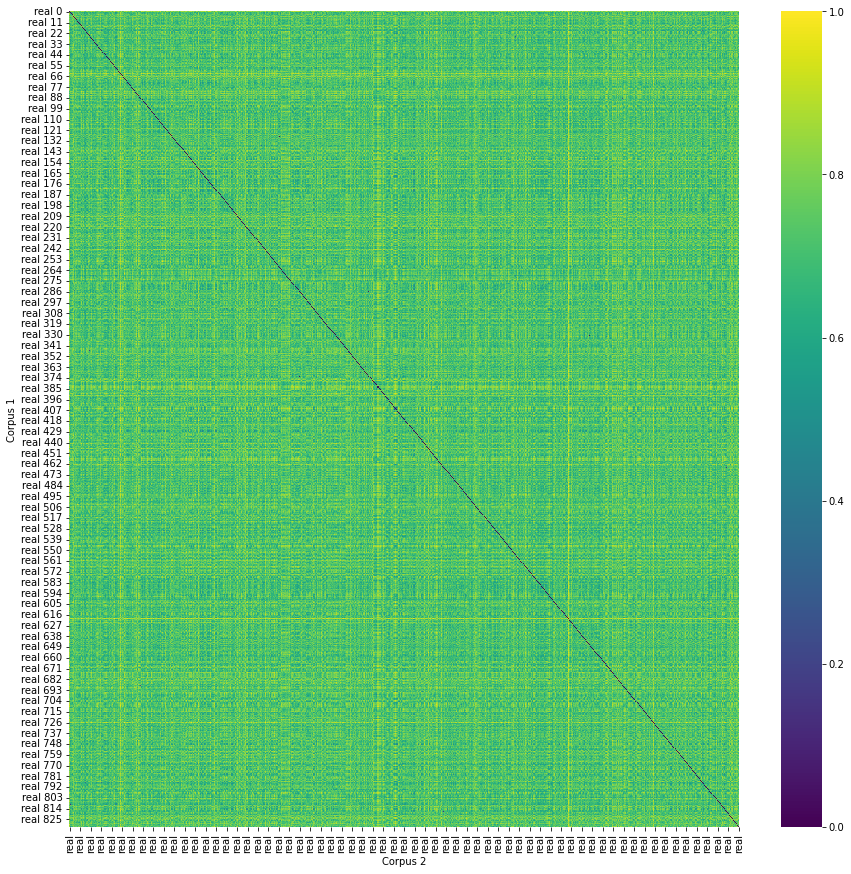

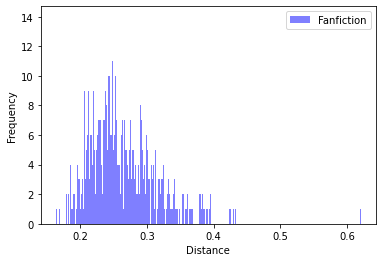

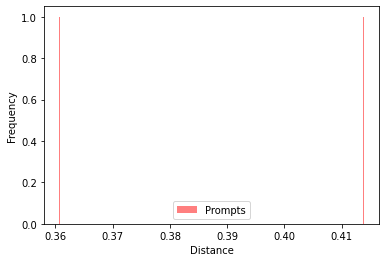

In [83]:
run_exp_for_all_topics(topics ,run_each_experiment,experimentpath ,exp_date)

In [84]:
def run_exp_for_all_topics_rp(topics , experiment_num , experimentpath , exp_date):
    for topic in topics:
        for experimentNum in range(1 ,experiment_num+1):
            to_spd = True
            print(f"Running Experiment {experimentNum} on {topic}")
            nonpromptsdis , promptsdis = run_Experiment_rp(experimentpath ,topic,exp_date, experiment_num = experimentNum 
                                                        , to_spd = to_spd)
            real_ranks , prompts_ranks = get_ranking(nonpromptsdis, promptsdis)
            sum_small_experiment(topic, experimentpath+topic+"/experiment-"+str(experimentNum), nonpromptsdis , promptsdis , exp_date , prompts_ranks)

In [85]:
experimentname = "EXP4-foodBlogs-16052023-prompts-WithSPD-clean"
experimentpath = experiment_main_folder+experimentname+"/"

Running Experiment 1 on foodBlogs
Within the range [0.1735, 0.2695], there are 30 prompts and 2 reals, with a frequency of 0.9375 and a recall of 1.0000
Within the range [0.1696, 0.1809], there are 2 reals and 23 prompts, with a frequency of 0.0800 and a recall of 1.0000


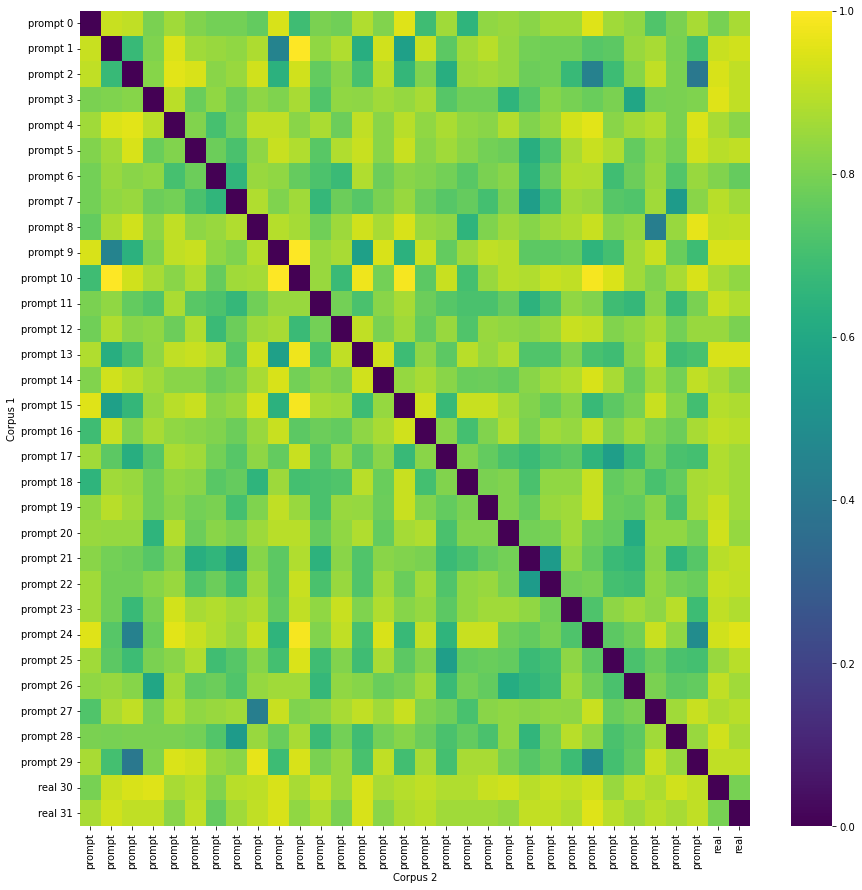

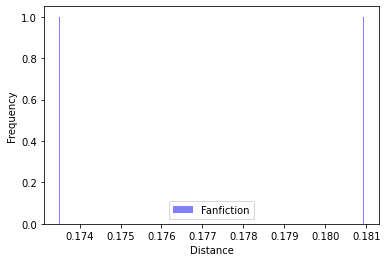

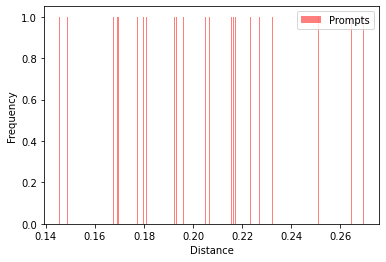

In [86]:
run_exp_for_all_topics_rp(topics ,run_each_experiment,experimentpath ,exp_date)

In [41]:
nonpromptsdis

,Distance
H2O_ Just Add Water_ Harry Potter - Owllover131 - Scylla Vanora The mo.csv-Signature.csv,0.247828
H2O_ Just Add Water_ Harry Potter - ScarlettAnderson99 - Of Mermaids a.csv-Signature.csv,0.319662
H2O_ Just Add Water_ Harry Potter - SimsFanatic - Harry potter and the.csv-Signature.csv,0.231146
H2O_ Just Add Water_ Harry Potter - WritersElemental - Hermione's Secr.csv-Signature.csv,0.324584
Halo_ Harry Potter - TimeLordSPARTAN - Halo and Hogwarts Book 1_ Maste.csv-Signature.csv,0.256472
...,...
Harry Potter_ Yumeiro P_tissi_re_ - Kai Chen - Escape to Baking.csv-Signature.csv,0.218897
Pitch Perfect - wishgrantingfactories - Harry Potters.csv-Signature.csv,0.321828
Powerpuff Girls - theflowermaid - Back in Townsville (PPG and Harry Po.csv-Signature.csv,0.298555
Write Harry Potter fanfiction set during Chamber of Secrets.csv-Signature.csv,0.257749
